# The Audio, Speech, Vision Processing Lab - Emotional Sound Database (ASVP-ESD)

## Description
The dataset contains 12.625 audio files. It contains speech and non-speech emotional sound. The data (audio) was collected from movies, tv shows, youtube, and other websites.

## Emotion Classes

The dataset contains a total of 12 distinct emotions:

* Boredome
* Neutral
* Happiness
* Sadness
* Anger
* Fear
* Surprise
* Disgust
* Excite
* Pleasure
* Pain

## File Naming

Each audio file has a unique filename. The filename consists of numberical identifiers (e.g. 02-01-06-01-02-105-02-01-02.wav) these identifiers define the stimulus characteristic.

### Filename Identifiers

1. Modality - (03 = audio-only)
2. Vocal Channel - (01 = speech, 02 = non speech)
3. Emotion - (01 = boredom/sigh, 02 = neutral/calm, 03 = happy/laugh/gaggle, 04 = sad/cry, 05 = angry/grunt/frustation, 06 = fearful/scream/panic, 07 = disgust/dislike/contempt, 08 = surprised/gasp/amazed, 09 = excited, 10 = pleasure, 11 = pain/groan, 12 = disappointment/disapproval, 13 = breath)
4. Emotional Intensity - (01 = normal, 02 = high)
5. Statement - (as it's non scripted this help to refer approcimately to data collected from the same period or source base on their rank)
6. Actor - (even number represent male, odd numbers represent female)
7. Age - (01 = above 65 years, 02 = above 20 , 03 = below 20 years)
8. Source - (01 & 02 = movies/youtube/website, 03 = movies)
9. Language - (01 = Chinese, 02 = English, 04 = French, others = russian/others)

Exaple: 03-01-06-01-02-12-02-01-02-16.wav = audio_only-speech-fearful/scream/panic-normal-statement-male_actor_12-(20, 65)-movies/youtube/website-english-similar_with_16_other_audio_files

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from glob import glob

import librosa
import librosa.display

import IPython.display as ipd

import torch
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T

from enum import Enum
from typing import Literal, List
from uuid import uuid4
import pathlib
import shutil

print(torch.__version__)
print(torchaudio.__version__)

1.12.1+cu102
0.12.1+cu102


## Data Preparation

The first step is to filter the audio files to the sub set of audio files that we are interested in. 

We are interested in the following characteristics:

* Speech or (just) Sound
* Enlish Language

We are interested in the following emotions:

* Happy
* Excited
* Tender
* Scared
* Angry
* Sad

It is needed to take steps to transform the "raw" data into a new sub set that meet these criteria. This step needs to be done first before it is possible to move on data analysis, or any other data related actions.


Firt, let's define the various types of identifiers as enums for easy use later.

In [2]:
# define base functionality of enum
class BaseEnum(str, Enum):

    def __str__(self) -> str:
        return self.value

    def __str__(self) -> str:
        return self.value


# the medium in which emotion is conveyed
class Modality(BaseEnum):

    AUDIO_ONLY = "03"


# the type of audio (speech, or non speech)
class VocalChannel(BaseEnum):

    SPEECH = "01"
    NON_SPEECH = "02"


# the type of emotion, this will be reduced to the base six methioned previously
class Emotion(BaseEnum):

    BOREDOM = "01"
    NEUTRAL = "02"
    HAPPY = "03"
    SAD = "04"
    ANGRY = "05"
    FEARFUL = "06"
    DISGUST = "07"
    SURPRISED = "08"
    EXCITED = "09"
    PLEASURE = "10"
    PAIN = "11"
    DISAPPOINTMENT = "12"
    BREATH = "13"


class EmotionalIntensity(BaseEnum):

    NORMAL = "01"
    HIGH = "02"


# the age of the person expressing an emotion
class Age(BaseEnum):

    ABOVE_65 = "01"
    BETWEEN_20_AND_64 = "02"
    BELOW_20 = "03"


# the sex of the actor in the audio file
class Sex(BaseEnum):

    MALE = "male"
    FEMALE = "female"


# the source of the audio
class Source(BaseEnum):

    WEBSITE = "01"
    YOUTUBE = "02"
    MOVIES = "03"


# the language spoken in the audio file
class Language(BaseEnum):

    CHINESE = "01"
    ENGLISH = "02"
    FRENCH = "03"
    OTHER = "others"
    

Send, let's define a method that identifies wheather the actor is male or female.

In [3]:
# even number represents male, odd number represents female
def get_sex_identifier(sex_identifier: int = None) -> Literal[Sex.MALE, Sex.FEMALE]:
    return Sex.MALE if sex_identifier / 2 else Sex.FEMALE

In [4]:
def get_file_name_from_full_path(file_path: str = None) -> str:
    return file_path.split("/")[-1]

Third and last, let's define a method that returns all audio files based on the provided identifiers.

In [5]:
def get_audio_files_by_identifiers(
    files: List[str],
    modality: List[Modality] = Modality.AUDIO_ONLY, 
    vocal_channel: VocalChannel = None,
    emotion: List[Emotion] = None, 
    emotional_intensity: List[EmotionalIntensity] = None,
    age: List[Age] = None,
    source: List[Source] = None,
    language: Language = Language.ENGLISH
) -> list:
    ret_val = list() # intialize the return value as an empty array

    for index, file in enumerate(files):
        # extract the file name from the full file path
        file_name = get_file_name_from_full_path(file_path=file)

        # remove the extension of the file name
        file_name = file_name.replace(".wav", '')

        # extract the identifiers from the file name
        file_identifiers = file_name.split("-")

        # there are 99 cases where the 
        if len(file_identifiers) > 8:
            # filter out the desired files by the criteria
            if file_identifiers[0] in modality \
                and file_identifiers[1] in vocal_channel \
                and file_identifiers[2] in emotion \
                and file_identifiers[3] in emotional_intensity \
                and file_identifiers[6] in age \
                and file_identifiers[7] in source \
                and file_identifiers[8] == language:
                    ret_val.append(file)

    return ret_val

    

Time to load in the data and see what we are working with

In [6]:
audio_files: List[str] = glob("../../data/asvp-esd/Audio/*/*.wav")
audio_files[:5]

['../../data/asvp-esd/Audio/actor_94/03-01-02-01-07-94-02-02-01-32.wav',
 '../../data/asvp-esd/Audio/actor_94/03-02-11-01-10-94-02-02-01-31.wav',
 '../../data/asvp-esd/Audio/actor_94/03-02-05-01-12-94-02-02-02-99.wav',
 '../../data/asvp-esd/Audio/actor_94/03-02-08-02-01-94-04-02-01-38.wav',
 '../../data/asvp-esd/Audio/actor_94/03-02-03-01-20-94-02-02-01-33.wav']

In [7]:
# the length of the python list represents the number of audio files
len(audio_files)

12625

Time to filter the audio files by the criteria set previously.

In [8]:
# speech files

## happy
happy_speech = get_audio_files_by_identifiers(
    files=audio_files, 
    modality=[Modality.AUDIO_ONLY], 
    vocal_channel=[VocalChannel.SPEECH], 
    emotion=[Emotion.HAPPY],
    emotional_intensity=[EmotionalIntensity.NORMAL, EmotionalIntensity.HIGH],
    age=[Age.BELOW_20, Age.BETWEEN_20_AND_64, Age.ABOVE_65],
    source=[Source.MOVIES, Source.WEBSITE, Source.YOUTUBE],
)

## excited
excited_speech = get_audio_files_by_identifiers(
    files=audio_files, 
    modality=[Modality.AUDIO_ONLY], 
    vocal_channel=[VocalChannel.SPEECH], 
    emotion=[Emotion.EXCITED],
    emotional_intensity=[EmotionalIntensity.NORMAL, EmotionalIntensity.HIGH],
    age=[Age.BELOW_20, Age.BETWEEN_20_AND_64, Age.ABOVE_65],
    source=[Source.MOVIES, Source.WEBSITE, Source.YOUTUBE],
)

## tender

## scared
scared_speech = get_audio_files_by_identifiers(
    files=audio_files, 
    modality=[Modality.AUDIO_ONLY], 
    vocal_channel=[VocalChannel.SPEECH], 
    emotion=[Emotion.FEARFUL],
    emotional_intensity=[EmotionalIntensity.NORMAL, EmotionalIntensity.HIGH],
    age=[Age.BELOW_20, Age.BETWEEN_20_AND_64, Age.ABOVE_65],
    source=[Source.MOVIES, Source.WEBSITE, Source.YOUTUBE],
)

## angry
angry_speech = get_audio_files_by_identifiers(
    files=audio_files, 
    modality=[Modality.AUDIO_ONLY], 
    vocal_channel=[VocalChannel.SPEECH], 
    emotion=[Emotion.ANGRY],
    emotional_intensity=[EmotionalIntensity.NORMAL, EmotionalIntensity.HIGH],
    age=[Age.BELOW_20, Age.BETWEEN_20_AND_64, Age.ABOVE_65],
    source=[Source.MOVIES, Source.WEBSITE, Source.YOUTUBE],
)

## sad
sad_speech = get_audio_files_by_identifiers(
    files=audio_files, 
    modality=[Modality.AUDIO_ONLY], 
    vocal_channel=[VocalChannel.SPEECH], 
    emotion=[Emotion.SAD],
    emotional_intensity=[EmotionalIntensity.NORMAL, EmotionalIntensity.HIGH],
    age=[Age.BELOW_20, Age.BETWEEN_20_AND_64, Age.ABOVE_65],
    source=[Source.MOVIES, Source.WEBSITE, Source.YOUTUBE],
)


# non speech files

## happy
happy_non_speech = get_audio_files_by_identifiers(
    files=audio_files, 
    modality=[Modality.AUDIO_ONLY], 
    vocal_channel=[VocalChannel.NON_SPEECH], 
    emotion=[Emotion.HAPPY],
    emotional_intensity=[EmotionalIntensity.NORMAL, EmotionalIntensity.HIGH],
    age=[Age.BELOW_20, Age.BETWEEN_20_AND_64, Age.ABOVE_65],
    source=[Source.MOVIES, Source.WEBSITE, Source.YOUTUBE],
)

## excited
excited_non_speech = get_audio_files_by_identifiers(
    files=audio_files, 
    modality=[Modality.AUDIO_ONLY], 
    vocal_channel=[VocalChannel.NON_SPEECH], 
    emotion=[Emotion.EXCITED],
    emotional_intensity=[EmotionalIntensity.NORMAL, EmotionalIntensity.HIGH],
    age=[Age.BELOW_20, Age.BETWEEN_20_AND_64, Age.ABOVE_65],
    source=[Source.MOVIES, Source.WEBSITE, Source.YOUTUBE],
)

## tender

## scared
scared_non_speech = get_audio_files_by_identifiers(
    files=audio_files, 
    modality=[Modality.AUDIO_ONLY], 
    vocal_channel=[VocalChannel.NON_SPEECH], 
    emotion=[Emotion.FEARFUL],
    emotional_intensity=[EmotionalIntensity.NORMAL, EmotionalIntensity.HIGH],
    age=[Age.BELOW_20, Age.BETWEEN_20_AND_64, Age.ABOVE_65],
    source=[Source.MOVIES, Source.WEBSITE, Source.YOUTUBE],
)

## angry
angry_non_speech = get_audio_files_by_identifiers(
    files=audio_files, 
    modality=[Modality.AUDIO_ONLY], 
    vocal_channel=[VocalChannel.NON_SPEECH], 
    emotion=[Emotion.ANGRY],
    emotional_intensity=[EmotionalIntensity.NORMAL, EmotionalIntensity.HIGH],
    age=[Age.BELOW_20, Age.BETWEEN_20_AND_64, Age.ABOVE_65],
    source=[Source.MOVIES, Source.WEBSITE, Source.YOUTUBE],
)

## sad
sad_non_speech = get_audio_files_by_identifiers(
    files=audio_files, 
    modality=[Modality.AUDIO_ONLY], 
    vocal_channel=[VocalChannel.NON_SPEECH], 
    emotion=[Emotion.SAD],
    emotional_intensity=[EmotionalIntensity.NORMAL, EmotionalIntensity.HIGH],
    age=[Age.BELOW_20, Age.BETWEEN_20_AND_64, Age.ABOVE_65],
    source=[Source.MOVIES, Source.WEBSITE, Source.YOUTUBE],
)

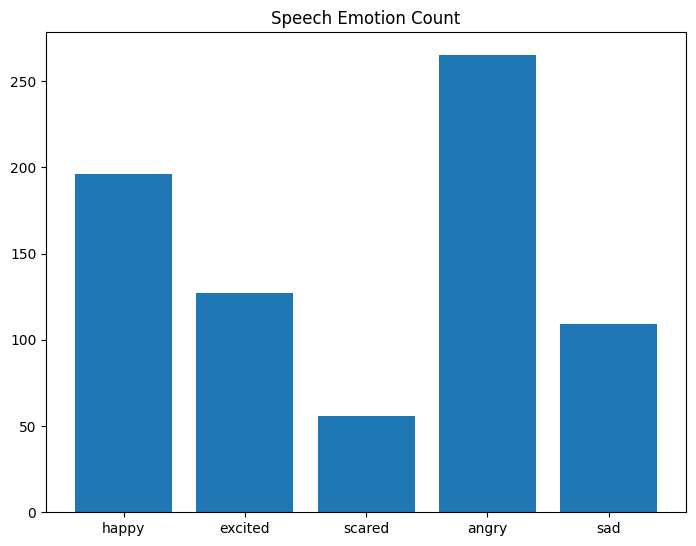

In [95]:
fig = plt.figure()

ax = fig.add_axes([0, 0, 1, 1])
ax.set_title("Speech Emotion Count")
emotions = ["happy", "excited", "scared", "angry", "sad"]
emotions_count = [len(happy_speech), len(excited_speech), len(scared_speech), len(angry_speech), len(sad_speech)]

ax.bar(emotions, emotions_count)
plt.show()

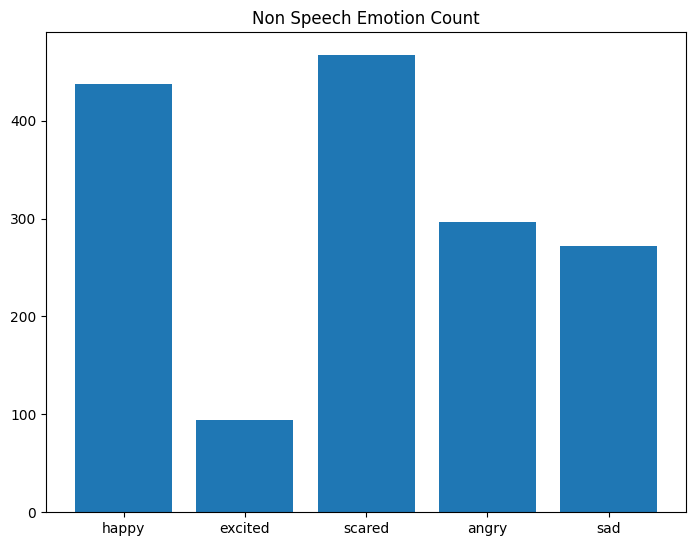

In [97]:
fig = plt.figure()

ax = fig.add_axes([0, 0, 1, 1])
ax.set_title("Non Speech Emotion Count")
emotions = ["happy", "excited", "scared", "angry", "sad"]
emotions_count = [len(happy_non_speech), len(excited_non_speech), len(scared_non_speech), len(angry_non_speech), len(sad_non_speech)]

ax.bar(emotions, emotions_count)
plt.show()

Both the speech data and non speech data are not equal in the amount of data available. This means that a future model when trained with this data will have a bias towards a specific emotion (the one trained on most).

## Saving the new data

In [11]:
# define base path
BASE_FILEPATH = "../../data/asvp-esd"

In [12]:
shutil.rmtree(path="../../data/asvp-esd/sound", ignore_errors=True)
shutil.rmtree(path="../../data/asvp-esd/speech", ignore_errors=True)

In [13]:
# initialize folders to save files to
for _, vocal_channel in enumerate(["sound", "speech"]):
    for _, emotion in enumerate(["happy", "excited", "tender", "scared", "angry", "sad"]):
        pathlib.Path(f"{BASE_FILEPATH}/{vocal_channel}/{emotion}").mkdir(parents=True, exist_ok=True)

In [14]:
# helper function to save new sub sets of audio files
def save_audio(audio_files: List[str] = None, vocal_channel: str = None, emotion: str = None):
    for _, audio_file in enumerate(audio_files):
        # load the waveform and sample rate of the audio file
        waveform, sr = torchaudio.backend.sox_io_backend.load(audio_file)

        # specify new file path & name, provide waveform & sample rate
        torchaudio.backend.sox_io_backend.save(
            filepath=f"{BASE_FILEPATH}/{vocal_channel}/{emotion}/{uuid4()}.wav", 
            src=waveform, 
            sample_rate=sr
        )

In [15]:
## happy
save_audio(audio_files=happy_speech, vocal_channel="speech", emotion="happy")
save_audio(audio_files=happy_non_speech, vocal_channel="sound", emotion="happy")

# excited
save_audio(audio_files=excited_speech, vocal_channel="speech", emotion="excited")
save_audio(audio_files=excited_non_speech, vocal_channel="sound", emotion="excited")

# tender

# scared
save_audio(audio_files=scared_speech, vocal_channel="speech", emotion="scared")
save_audio(audio_files=scared_non_speech, vocal_channel="sound", emotion="scared")

# angry
save_audio(audio_files=angry_speech, vocal_channel="speech", emotion="angry")
save_audio(audio_files=angry_non_speech, vocal_channel="sound", emotion="angry")

# sad
save_audio(audio_files=sad_speech, vocal_channel="speech", emotion="sad")
save_audio(audio_files=sad_non_speech, vocal_channel="sound", emotion="sad")

## Analyse new data

In [16]:
def plot_waveform(waveform: torch.Tensor, sr: int, title: str = "Waveform"):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sr

    figure, axes = plt.subplots(num_channels, 1)
    axes.plot(time_axis, waveform[0], linewidth=1)
    axes.grid(True)
    
    figure.suptitle(title)

    plt.show(block=False)


def plot_spectogram(specgram, title: str = "Spectogram (db)", ylabel="freq_bin") -> None:
    fig, axs = plt.subplots(1, 1)

    axs.set_title(title)
    axs.set_ylabel(ylabel)
    axs.set_xlabel("frame")

    im = axs.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto")
    fig.colorbar(im, ax=axs)

    plt.show(block=False)


def plot_fbank(fbank, title: str = "Filter bank") -> None:
    fig, axs = plt.subplots(1, 1)

    axs.set_title(title)
    axs.imshow(fbank, aspect="auto")
    axs.set_ylabel("freq_bin")
    axs.set_xlabel("mel_bin")

    plt.show()


def plot_pitch(waveform: torch.Tensor, sr: int, pitch: torch.Tensor) -> None:
    figure, axis = plt.subplots(1, 1)
    axis.set_title("Pitch Feature")
    axis.grid(True)

    end_time = waveform.shape[1] / sr
    time_axis = torch.linspace(0, end_time, waveform.shape[1])
    axis.plot(time_axis, waveform[0], linewidth=1, color="gray", alpha=0.3)

    axis2 = axis.twinx()
    time_axis = torch.linspace(0, end_time, pitch.shape[1])
    axis2.plot(time_axis, pitch[0], linewidth=2, label="Pitch", color="green")

    axis2.legend(loc=0)
    plt.show(block=False)

### Non Speech

In [17]:
happy_non_speech: List[str] = glob("../../data/asvp-esd/sound/happy/*.wav")
excited_non_speech: List[str] = glob("../../data/asvp-esd/sound/excited/*.wav")
angry_non_speech: List[str] = glob("../../data/asvp-esd/sound/angry/*.wav")
sad_non_speech: List[str] = glob("../../data/asvp-esd/sound/sad/*.wav")
scared_non_speech: List[str] = glob("../../data/asvp-esd/sound/scared/*.wav")

Let's find out the minimum, average and maximum duration of the audio.

In [18]:
# helper function to calculate minimum, maximum and average audio duration
def get_min_max_avg_duration(audio_files):
    minimum = 0
    maximum = 0
    total = 0

    waveform, sr = torchaudio.load(audio_files[0])
    num_channels, num_frames = waveform.shape
    minimum = maximum = num_frames / sr

    for _, audio_file in enumerate(audio_files[1:]):
        waveform, sr = torchaudio.load(audio_file)
        num_channels, num_frames = waveform.shape
        
        duration = num_frames / sr

        total += duration

        if minimum > duration:
            minimum = duration
        if maximum < duration:
            maximum = duration

    return minimum, maximum, total / len(audio_files)

In [19]:
get_min_max_avg_duration(happy_non_speech)

(0.3910625, 15.699625, 4.763889982876714)

In [20]:
get_min_max_avg_duration(excited_non_speech)

(0.528125, 18.319125, 2.604834441489362)

In [21]:
get_min_max_avg_duration(angry_non_speech)

(0.2314375, 15.968, 2.35999116161616)

In [22]:
get_min_max_avg_duration(sad_non_speech)

(0.406375, 25.8101875, 7.227077665441173)

In [23]:
get_min_max_avg_duration(scared_non_speech)

(0.1431875, 25.3965, 3.103809957173448)

From the above calculations it is vissible that none of the different audio files are of the same duration, or even same minimum and/or maximum duration.

### Happy

In [24]:
waveform, sr = torchaudio.load(happy_non_speech[0])
waveform, sr

(tensor([[ 3.0518e-05,  0.0000e+00, -3.0518e-05,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00]]),
 16000)

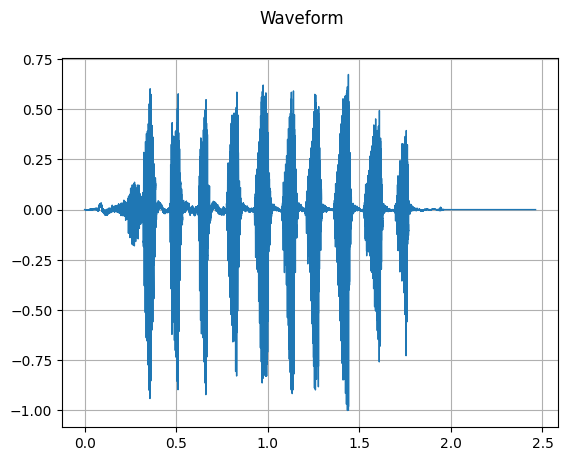

In [25]:
plot_waveform(waveform, sr, title="Waveform")
ipd.Audio(waveform.numpy(), rate=sr)

#### Spectogram

In [26]:
n_fft = 1024
win_length = None
hop_length = 512

# define transform
spec_transorm = T.Spectrogram(
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode="reflect",
    power=2.0
)

In [27]:
# apply transform
spec = spec_transorm(waveform)
spec.shape

torch.Size([1, 513, 77])

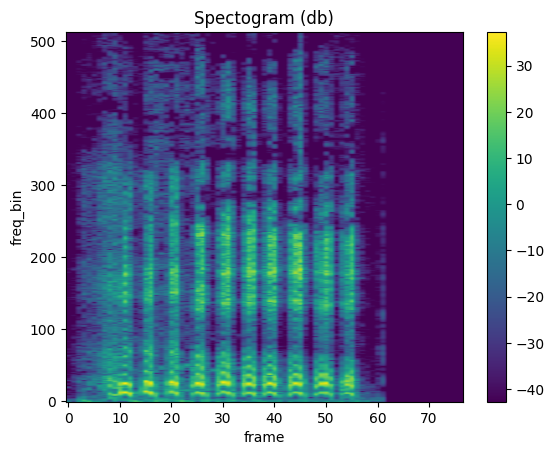

In [28]:
plot_spectogram(specgram=spec[0])

#### Mel Spectogram

In [29]:
n_fft = 1024
win_length = None
hop_length = 512
n_mels = 128

# define transform
mel_transform = T.MelSpectrogram(
    sample_rate=sr,
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode="reflect",
    power=2.0,
    norm="slaney",
    onesided=True,
    n_mels=n_mels,
    mel_scale="htk",
)

In [30]:
# apply transform
mel_spec = mel_transform(waveform)
mel_spec.shape

torch.Size([1, 128, 77])

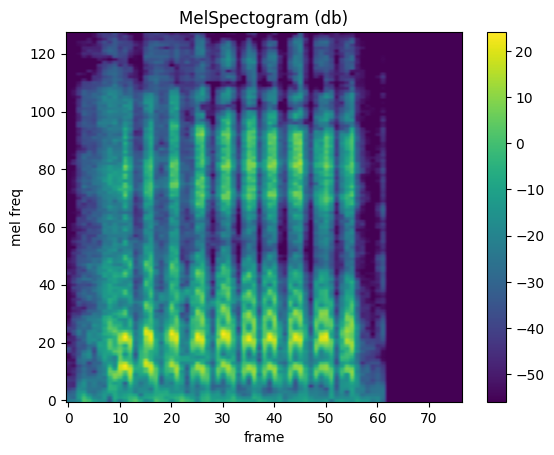

In [31]:
plot_spectogram(mel_spec[0], title="MelSpectogram (db)", ylabel="mel freq")

#### Mel Frequency Cepstral Coefficients

In [32]:
n_fft = 2048
win_length = None
hop_length = 512
n_mels = 256
n_mfcc = 256

# define transform
mfcc_transform = T.MFCC(
    sample_rate=sr,
    n_mfcc=n_mfcc,
    melkwargs={
        "n_fft": n_fft,
        "n_mels": n_mels,
        "hop_length": hop_length,
        "mel_scale": "htk",
    },
)

In [33]:
# apply transform
mfcc_spec = mfcc_transform(waveform)
mfcc_spec.shape

torch.Size([1, 256, 77])

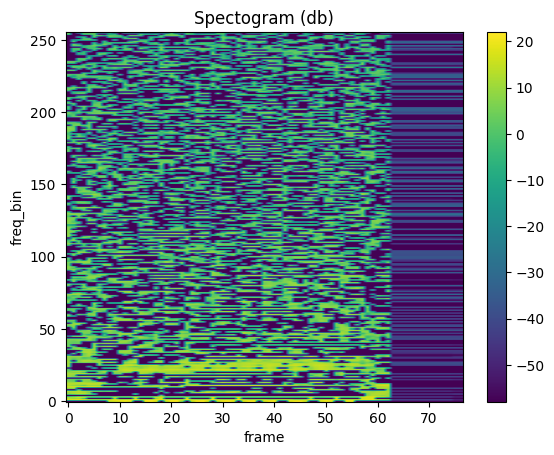

In [34]:
plot_spectogram(mfcc_spec[0])

#### Linear Frequency Cepstral Coefficients

In [35]:
n_fft = 2048
win_length = None
hop_length = 512
n_lfcc = 256

# define transform
lfcc_transform = T.LFCC(
    sample_rate=sr,
    n_lfcc=n_lfcc,
    speckwargs={
        "n_fft": n_fft,
        "win_length": win_length,
        "hop_length": hop_length,
    },
)

In [36]:
# apply transform
lfcc_spec = lfcc_transform(waveform)
lfcc_spec.shape

torch.Size([1, 256, 77])

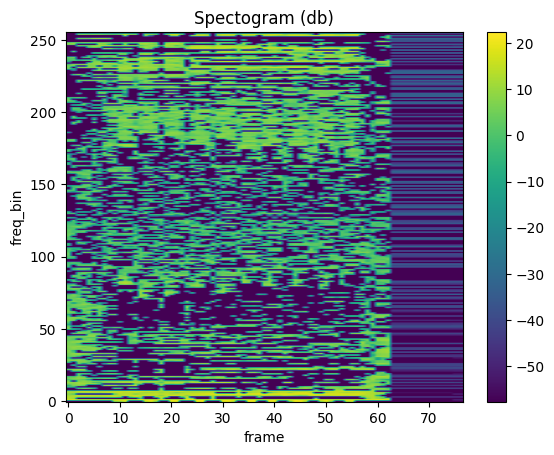

In [37]:
plot_spectogram(lfcc_spec[0])

### Excited

In [38]:
waveform, sr = torchaudio.load(excited_non_speech[0])
waveform, sr

(tensor([[0., 0., 0.,  ..., 0., 0., 0.]]), 16000)

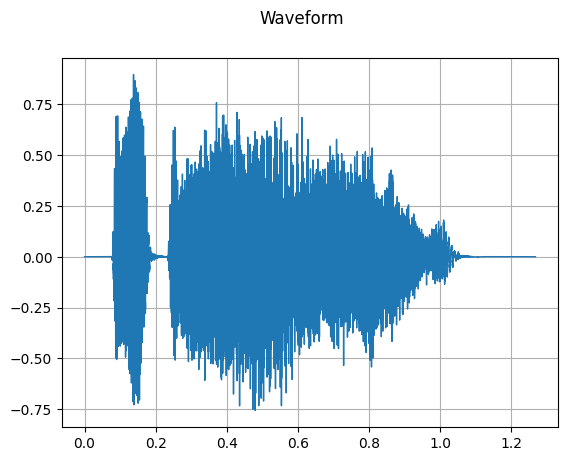

In [39]:
plot_waveform(waveform, sr, title="Waveform")
ipd.Audio(waveform.numpy(), rate=sr)

#### Spectogram

In [40]:
n_fft = 1024
win_length = None
hop_length = 512

# define transform
spec_transorm = T.Spectrogram(
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode="reflect",
    power=2.0
)

In [41]:
# apply transform
spec = spec_transorm(waveform)
spec.shape

torch.Size([1, 513, 40])

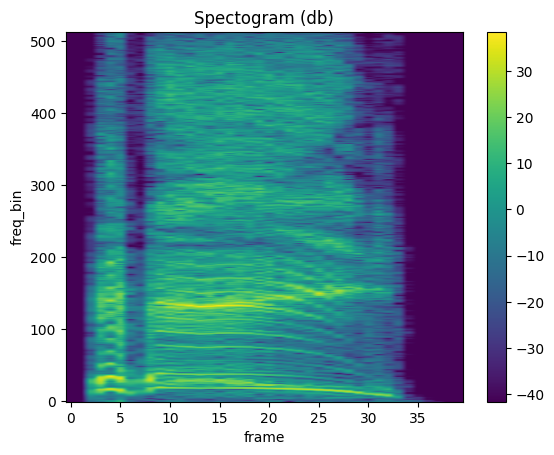

In [42]:
plot_spectogram(specgram=spec[0])

#### Mel Spectogram

In [43]:
n_fft = 1024
win_length = None
hop_length = 512
n_mels = 128

# define transform
mel_transform = T.MelSpectrogram(
    sample_rate=sr,
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode="reflect",
    power=2.0,
    norm="slaney",
    onesided=True,
    n_mels=n_mels,
    mel_scale="htk",
)

In [44]:
# apply transform
mel_spec = mel_transform(waveform)
mel_spec.shape

torch.Size([1, 128, 40])

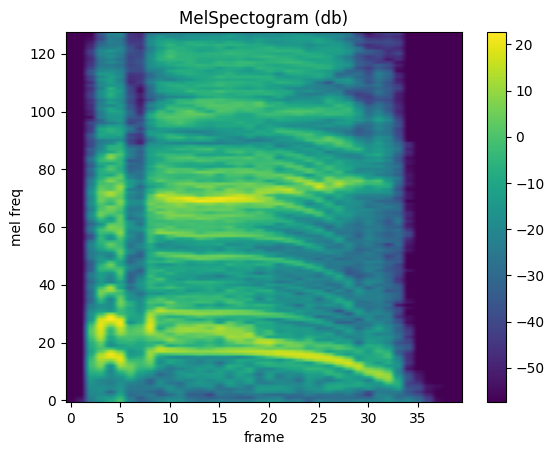

In [45]:
plot_spectogram(mel_spec[0], title="MelSpectogram (db)", ylabel="mel freq")

#### Mel Frequency Cepstral Coefficients

In [46]:
n_fft = 2048
win_length = None
hop_length = 512
n_mels = 256
n_mfcc = 256

# define transform
mfcc_transform = T.MFCC(
    sample_rate=sr,
    n_mfcc=n_mfcc,
    melkwargs={
        "n_fft": n_fft,
        "n_mels": n_mels,
        "hop_length": hop_length,
        "mel_scale": "htk",
    },
)

In [47]:
# apply transform
mfcc_spec = mfcc_transform(waveform)
mfcc_spec.shape

torch.Size([1, 256, 40])

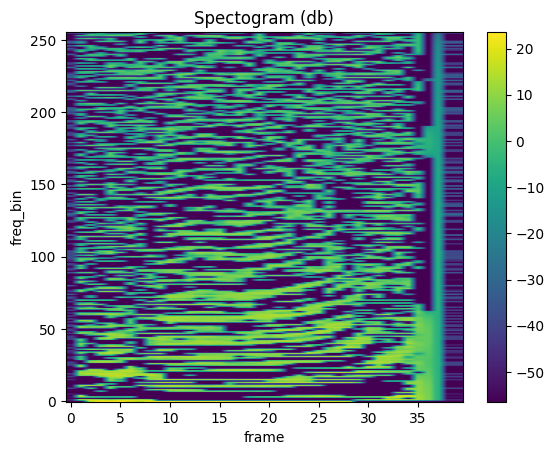

In [48]:
plot_spectogram(mfcc_spec[0])

#### Linear Frequency Cepstral Coefficients

In [49]:
n_fft = 2048
win_length = None
hop_length = 512
n_lfcc = 256

# define transform
lfcc_transform = T.LFCC(
    sample_rate=sr,
    n_lfcc=n_lfcc,
    speckwargs={
        "n_fft": n_fft,
        "win_length": win_length,
        "hop_length": hop_length,
    },
)

In [50]:
# apply transform
lfcc_spec = lfcc_transform(waveform)
lfcc_spec.shape

torch.Size([1, 256, 40])

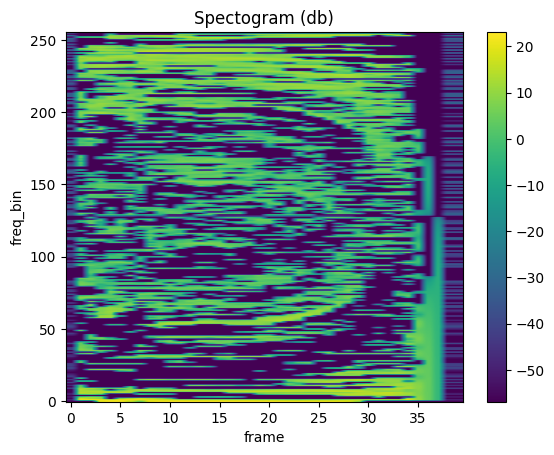

In [51]:
plot_spectogram(lfcc_spec[0])

### Angry

In [52]:
waveform, sr = torchaudio.load(angry_non_speech[1])
waveform, sr

(tensor([[-0.0013, -0.0013, -0.0011,  ...,  0.0009,  0.0008,  0.0009]]), 16000)

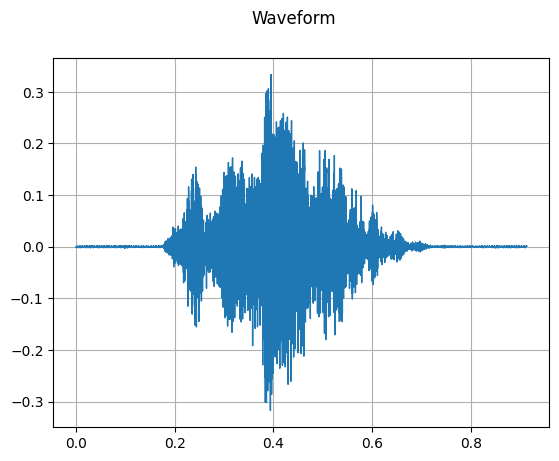

In [53]:
plot_waveform(waveform, sr, title="Waveform")
ipd.Audio(waveform.numpy(), rate=sr)

#### Spectogram

In [54]:
n_fft = 1024
win_length = None
hop_length = 512

# define transform
spec_transorm = T.Spectrogram(
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode="reflect",
    power=2.0
)

In [55]:
# apply transform
spec = spec_transorm(waveform)
spec.shape

torch.Size([1, 513, 29])

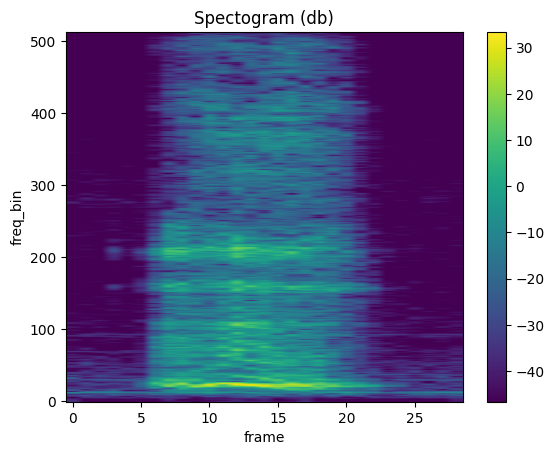

In [56]:
plot_spectogram(specgram=spec[0])

#### Mel Spectogram

In [57]:
n_fft = 1024
win_length = None
hop_length = 512
n_mels = 128

# define transform
mel_transform = T.MelSpectrogram(
    sample_rate=sr,
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode="reflect",
    power=2.0,
    norm="slaney",
    onesided=True,
    n_mels=n_mels,
    mel_scale="htk",
)

In [58]:
# apply transform
mel_spec = mel_transform(waveform)
mel_spec.shape

torch.Size([1, 128, 29])

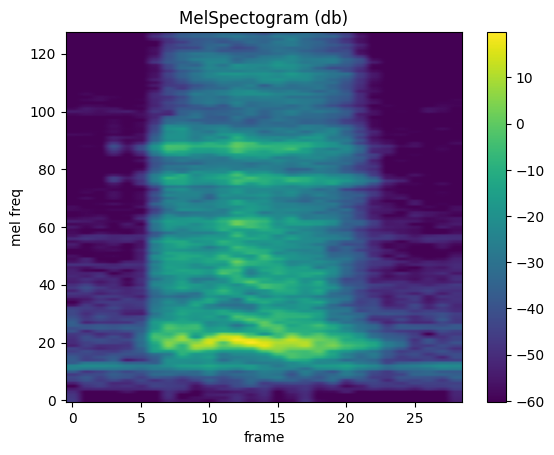

In [59]:
plot_spectogram(mel_spec[0], title="MelSpectogram (db)", ylabel="mel freq")

#### Mel Frequency Cepstral Coefficients

In [60]:
n_fft = 2048
win_length = None
hop_length = 512
n_mels = 256
n_mfcc = 256

# define transform
mfcc_transform = T.MFCC(
    sample_rate=sr,
    n_mfcc=n_mfcc,
    melkwargs={
        "n_fft": n_fft,
        "n_mels": n_mels,
        "hop_length": hop_length,
        "mel_scale": "htk",
    },
)

In [61]:
# apply transform
mfcc_spec = mfcc_transform(waveform)
mfcc_spec.shape

torch.Size([1, 256, 29])

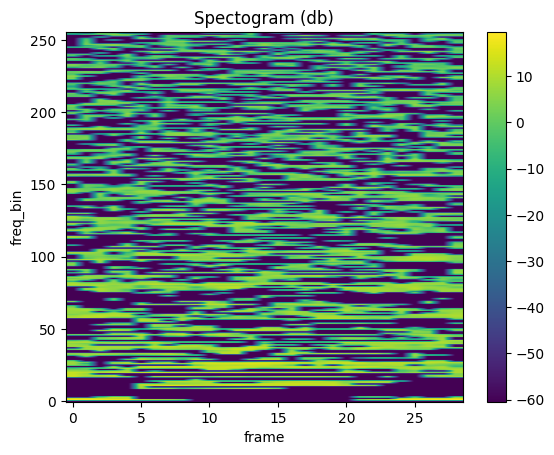

In [62]:
plot_spectogram(mfcc_spec[0])

#### Linear Frequency Cepstral Coefficients

In [63]:
n_fft = 2048
win_length = None
hop_length = 512
n_lfcc = 256

# define transform
lfcc_transform = T.LFCC(
    sample_rate=sr,
    n_lfcc=n_lfcc,
    speckwargs={
        "n_fft": n_fft,
        "win_length": win_length,
        "hop_length": hop_length,
    },
)

In [64]:
# apply transform
lfcc_spec = lfcc_transform(waveform)
lfcc_spec.shape

torch.Size([1, 256, 29])

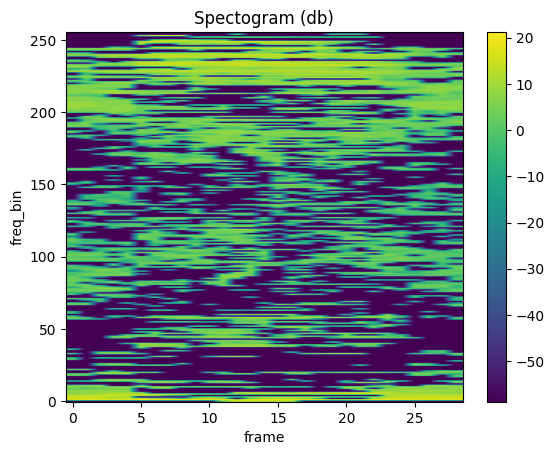

In [65]:
plot_spectogram(lfcc_spec[0])

### Sad

In [66]:
waveform, sr = torchaudio.load(sad_non_speech[0])
waveform, sr

(tensor([[-0.0121, -0.0094, -0.0098,  ..., -0.0118, -0.0033,  0.0042]]), 16000)

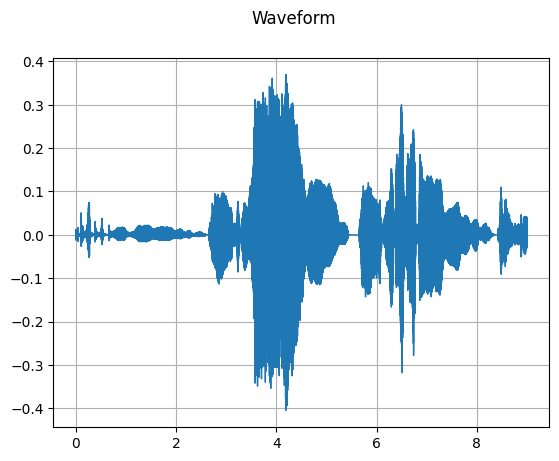

In [67]:
plot_waveform(waveform, sr, title="Waveform")
ipd.Audio(waveform.numpy(), rate=sr)

#### Spectogram

In [68]:
n_fft = 1024
win_length = None
hop_length = 512

# define transform
spec_transorm = T.Spectrogram(
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode="reflect",
    power=2.0
)

In [69]:
# apply transform
spec = spec_transorm(waveform)
spec.shape

torch.Size([1, 513, 282])

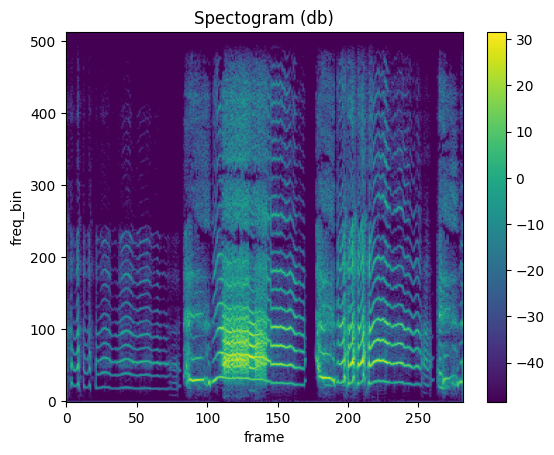

In [70]:
plot_spectogram(specgram=spec[0])

#### Mel Spectogram

In [71]:
n_fft = 1024
win_length = None
hop_length = 512
n_mels = 128

# define transform
mel_transform = T.MelSpectrogram(
    sample_rate=sr,
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode="reflect",
    power=2.0,
    norm="slaney",
    onesided=True,
    n_mels=n_mels,
    mel_scale="htk",
)

In [72]:
# apply transform
mel_spec = mel_transform(waveform)
mel_spec.shape

torch.Size([1, 128, 282])

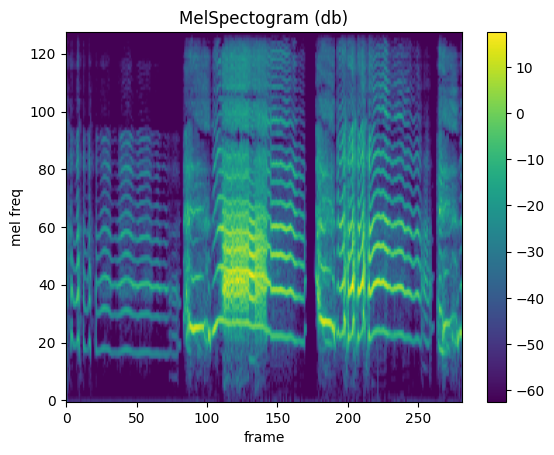

In [73]:
plot_spectogram(mel_spec[0], title="MelSpectogram (db)", ylabel="mel freq")

#### Mel Frequency Cepstral Coefficients

In [74]:
n_fft = 2048
win_length = None
hop_length = 512
n_mels = 256
n_mfcc = 256

# define transform
mfcc_transform = T.MFCC(
    sample_rate=sr,
    n_mfcc=n_mfcc,
    melkwargs={
        "n_fft": n_fft,
        "n_mels": n_mels,
        "hop_length": hop_length,
        "mel_scale": "htk",
    },
)

In [75]:
# apply transform
mfcc_spec = mfcc_transform(waveform)
mfcc_spec.shape

torch.Size([1, 256, 282])

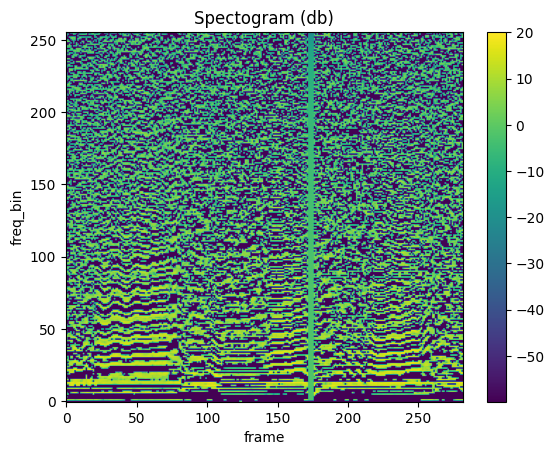

In [76]:
plot_spectogram(mfcc_spec[0])

#### Linear Frequency Cepstral Coefficients

In [77]:
n_fft = 2048
win_length = None
hop_length = 512
n_lfcc = 256

# define transform
lfcc_transform = T.LFCC(
    sample_rate=sr,
    n_lfcc=n_lfcc,
    speckwargs={
        "n_fft": n_fft,
        "win_length": win_length,
        "hop_length": hop_length,
    },
)

In [78]:
# apply transform
lfcc_spec = lfcc_transform(waveform)
lfcc_spec.shape

torch.Size([1, 256, 282])

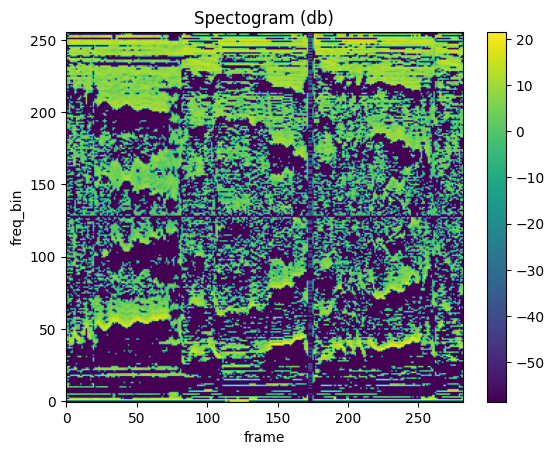

In [79]:
plot_spectogram(lfcc_spec[0])

### Scared

In [80]:
waveform, sr = torchaudio.load(scared_non_speech[2])
waveform, sr

(tensor([[3.0518e-05, 3.0518e-05, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
          0.0000e+00]]),
 16000)

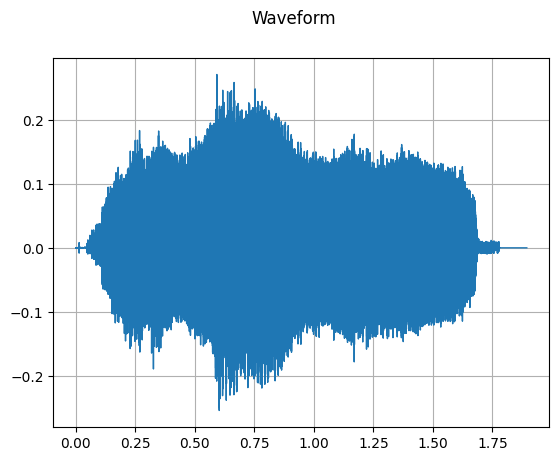

In [81]:
plot_waveform(waveform, sr, title="Waveform")
ipd.Audio(waveform.numpy(), rate=sr)

#### Spectogram

In [82]:
n_fft = 1024
win_length = None
hop_length = 512

# define transform
spec_transorm = T.Spectrogram(
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode="reflect",
    power=2.0
)

In [83]:
# apply transform
spec = spec_transorm(waveform)
spec.shape

torch.Size([1, 513, 60])

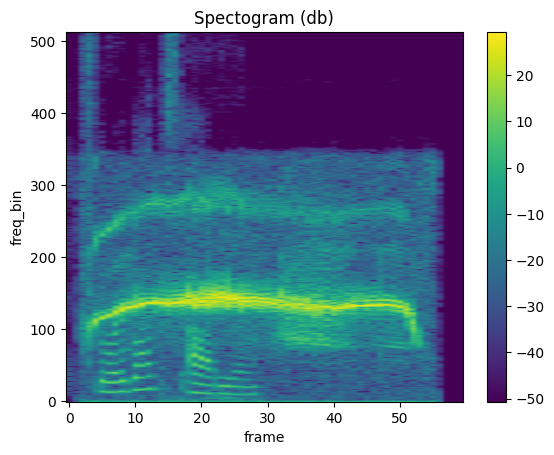

In [84]:
plot_spectogram(specgram=spec[0])

#### Mel Spectogram

In [85]:
n_fft = 1024
win_length = None
hop_length = 512
n_mels = 128

# define transform
mel_transform = T.MelSpectrogram(
    sample_rate=sr,
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode="reflect",
    power=2.0,
    norm="slaney",
    onesided=True,
    n_mels=n_mels,
    mel_scale="htk",
)

In [86]:
# apply transform
mel_spec = mel_transform(waveform)
mel_spec.shape

torch.Size([1, 128, 60])

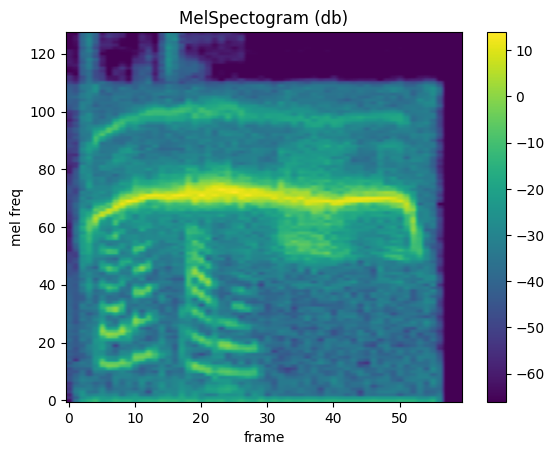

In [87]:
plot_spectogram(mel_spec[0], title="MelSpectogram (db)", ylabel="mel freq")

#### Mel Frequency Cepstral Coefficients

In [88]:
n_fft = 2048
win_length = None
hop_length = 512
n_mels = 256
n_mfcc = 256

# define transform
mfcc_transform = T.MFCC(
    sample_rate=sr,
    n_mfcc=n_mfcc,
    melkwargs={
        "n_fft": n_fft,
        "n_mels": n_mels,
        "hop_length": hop_length,
        "mel_scale": "htk",
    },
)

In [89]:
# apply transform
mfcc_spec = mfcc_transform(waveform)
mfcc_spec.shape

torch.Size([1, 256, 60])

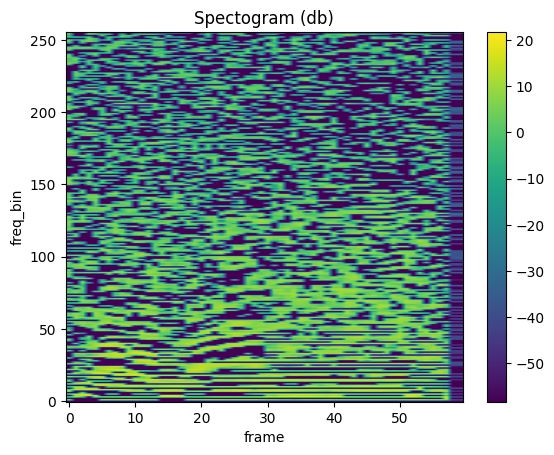

In [90]:
plot_spectogram(mfcc_spec[0])

#### Linear Frequency Cepstral Coefficients

In [91]:
n_fft = 2048
win_length = None
hop_length = 512
n_lfcc = 256

# define transform
lfcc_transform = T.LFCC(
    sample_rate=sr,
    n_lfcc=n_lfcc,
    speckwargs={
        "n_fft": n_fft,
        "win_length": win_length,
        "hop_length": hop_length,
    },
)

In [92]:
# apply transform
lfcc_spec = lfcc_transform(waveform)
lfcc_spec.shape

torch.Size([1, 256, 60])

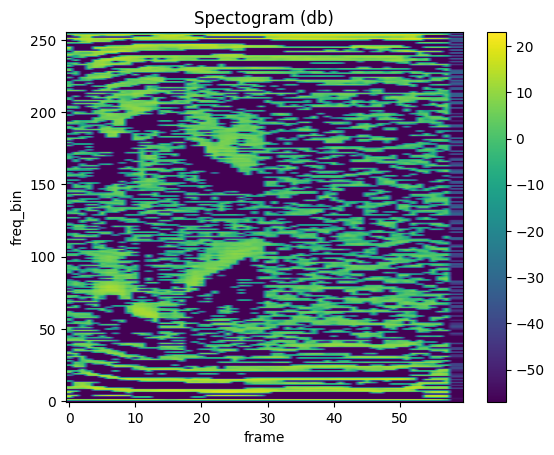

In [93]:
plot_spectogram(lfcc_spec[0])

## Conclusion

Unfortunatelly the data provided in this dataset is not usefull for training. The data is unbalanced, the different emotions are of different amounts, while also the duration of the various files are also different. By having an unballanced amount of emotions the potential model will have a bias towards the emotion it is trained most. Also by not having a standard duration, it required a lot of data cleaning and preparation to "mold" the data into a suitable shape into a model. It's not worth to go this way when there are better options available within the team. I do suggest however to use this dataset for potential testing, the "chaotic" nature of the dataset does make it a good canditate to be emulate real life situations while testing.